In [ ]:
# Q1. a

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from scipy import signal

In [2]:
def toeplitz(column,length):
    toeplitz = np.zeros((len(column),length))
    if np.sum(np.abs(column)) == 0:
        return toeplitz
    n = len(column)
    for i in range(length):
        toeplitz[i:,i] = column[:n-i]
        toeplitz[:i,i] = column[n-i:]
    return toeplitz

In [3]:
def conv2d_toeplitz(image,filter):
    
    (h_filter, l_filter) = filter.shape
    (h_image, l_image) = image.shape
    
    h_out = h_filter + h_image - 1
    l_out = l_filter + l_image - 1
    
    padded_filter = np.zeros((h_out,l_out))
    padded_filter[h_out - h_filter:, :l_filter] = filter
    
    toeplitz_matrix_index = toeplitz(range(h_out), h_image)
    toeplitz_matrix_index = toeplitz_matrix_index.astype(np.int)
    
    toeplitz_elements = np.zeros((h_out, l_out, l_image))

    for i in range(h_out):
        toeplitz_elements[i,:,:] = toeplitz(padded_filter[h_out - i - 1], l_image)
        
    flattened_image = np.flip(image, axis = 0).reshape(np.shape(image)[0] * np.shape(image)[1])
    
    toeplitz_matrix_row = np.zeros((l_out, h_image * l_image))
    final_output = np.zeros((h_out, l_out))
    
    number_of_multiplications = 0
    
    for i in range(h_out):
        for j in range(h_image):
            toeplitz_matrix_row[:, h_image * j : h_image * (j+1)] = toeplitz_elements[toeplitz_matrix_index[i,j],:,:]
        final_output[h_out - 1 - i, :] = np.matmul(toeplitz_matrix_row, flattened_image)
        number_of_multiplications += l_out * h_image * l_image
    
    return final_output, number_of_multiplications

In [4]:
def toeplitz_list(column,length):
    column = np.array(column)
    if np.sum(np.abs(column)) == 0:
        return np.zeros((len(column),length))
    n = len(column)
    toeplitz = [np.concatenate((column[n-i:],column[:n-i])) for i in range(length)]
    return np.transpose(toeplitz)

In [15]:
def conv2d_toeplitz_list(image,filter):
    
    (h_filter, l_filter) = filter.shape
    (h_image, l_image) = image.shape
    
    h_out = h_filter + h_image - 1
    l_out = l_filter + l_image - 1
    
    padded_filter = np.zeros((h_out, l_out))
    padded_filter[h_out - h_filter :, : l_filter] = filter
    
    toeplitz_matrix_index = toeplitz_list(range(h_out), h_image)
    toeplitz_matrix_index = toeplitz_matrix_index.astype(np.int)
    
    toeplitz_elements = np.array([toeplitz_list(padded_filter[h_out - i - 1], l_image) for i in range(h_out)])
    
    flattened_image = np.flip(image, axis = 0).reshape(np.shape(image)[0] * np.shape(image)[1])
    
    toeplitz_matrix_row = np.zeros((l_out, h_image * l_image))
    final_output = np.zeros((h_out, l_out))
    
    number_of_multiplications = 0
    
    final_output = [np.matmul(np.concatenate([toeplitz_elements[toeplitz_matrix_index[i ,j], :, :] for j in range(h_image)], axis=1), flattened_image) for i in range(h_out)]
    
    return np.flip(final_output,axis = 0)

In [16]:
input = np.array([[1,2,3],[4,5,6],[7,8,9]])
filter = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

output, n_muls = conv2d_toeplitz(input, filter)

print(output)
print("Number of multiplications = " + str(n_muls))

[[  1.   4.   8.   8.   3.]
 [  4.  13.  20.  17.   6.]
 [  6.  18.  24.  18.   6.]
 [ -4. -13. -20. -17.  -6.]
 [ -7. -22. -32. -26.  -9.]]
Number of multiplications = 225


In [ ]:
# Q1 b.

In [17]:
lena = cv2.imread("/home/harish/Documents/Python Scripts/IVP Lab/Assignment2/lena.jpg")
lena = lena[:,:,0]
lena = cv2.resize(lena,(100,100))

In [18]:
t1 = time.time()
output, number_of_multiplications = conv2d_toeplitz(lena,np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])/16)
t2 = time.time()

In [19]:
t3 = time.time()
list_output = conv2d_toeplitz_list(lena,np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])/16)
t4 = time.time()

In [20]:
t5 = time.time()
scipy_output = signal.convolve2d(lena,np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]])/16)
t6 = time.time()

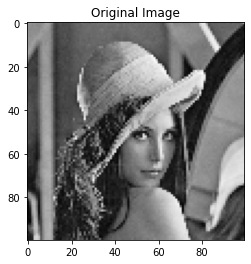

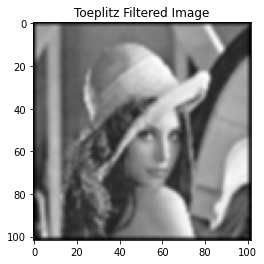

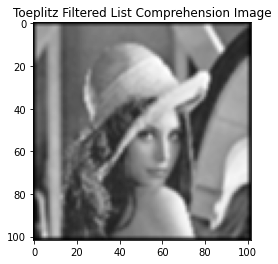

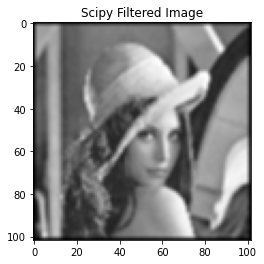

Number of multiplications = 104040000


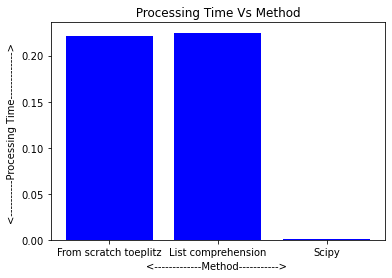

In [21]:
plt.imshow(lena,cmap = "gray")
plt.title('Original Image')
plt.show()
plt.imshow(output,cmap = "gray")
plt.title('Toeplitz Filtered Image')
plt.show()
plt.imshow(list_output,cmap = "gray")
plt.title('Toeplitz Filtered List Comprehension Image')
plt.show()
plt.imshow(scipy_output,cmap = "gray")
plt.title('Scipy Filtered Image')
plt.show()
print("Number of multiplications = " + str(number_of_multiplications))

x = ['From scratch toeplitz', 'List comprehension', 'Scipy']
Processing_Times = [t2-t1,t4-t3,t6-t5]
x_pos = [i for i in range(len(x))]
plt.bar(x_pos, Processing_Times, color='blue')
plt.xlabel("<-------------Method-----------> ")
plt.ylabel("<----------Processing Time-------------> ")
plt.title(" Processing Time Vs Method ")
plt.xticks(x_pos, x)
plt.show()

([1,4,6,4,1], [4,16,24,16,4], [6,24,36,24,6], [4,16,24,16,4], [1,4,6,4,1])/256 can be split into a horizontal convolution of [1,4,6,4,1]/16 and a vertical convolution of [1,4,6,4,1]/16.

In [ ]:
# Q2

In [22]:
def padded_n(image,n):
    pad = int(n/2)
    image = np.array(image)
    padded_image = np.zeros((np.shape(image)[0]+pad*2,np.shape(image)[1]+pad*2))
    padded_image[pad:np.shape(image)[0]+pad,pad:np.shape(image)[1]+pad] = image
    return padded_image

In [23]:
def spat_sep_conv(image_2d,kernel_1d):
    no_of_multiplications = 0
    n = len(kernel_1d)
    pad = int(n/2)
    padded_image = padded_n(image_2d,n)
    conv1d = np.zeros(np.shape(image_2d))
    for i in range(pad,pad+np.shape(image_2d)[0]):
        for j in range(0,np.shape(image_2d)[1]):
            conv1d[i-pad,j] = np.dot(kernel_1d,padded_image[i,j:j+n])
            no_of_multiplications += n
    padded_conv1d = padded_n(conv1d,n)
    conv2d = np.zeros(np.shape(image_2d))
    for i in range(0,np.shape(image_2d)[0]):
        for j in range(pad,pad+np.shape(image_2d)[1]):
            conv2d[i,j-pad] = np.dot(kernel_1d,padded_conv1d[i:i+n,j])
            no_of_multiplications += n
    return conv2d,no_of_multiplications

In [24]:
def spat_sep_conv_list(image_2d,kernel_1d):
    n = len(kernel_1d)
    pad = int(n/2)
    padded_image = padded_n(image_2d,n)
    conv1d = [[np.dot(kernel_1d,padded_image[i,j:j+n]) for j in range(0,np.shape(image_2d)[1])] for i in range(pad,pad+np.shape(image_2d)[0])]
    padded_conv1d = padded_n(conv1d,n)
    
    conv2d = [[np.dot(kernel_1d,padded_conv1d[i:i+n,j]) for j in range(pad,pad+np.shape(image_2d)[1])] for i in range(0,np.shape(image_2d)[0])]

    return conv2d

In [25]:
t1 = time.time()
filtered_image,number_of_multiplications = spat_sep_conv(lena,np.array([1,4,6,4,1])/16)
t2 = time.time()
filtered_image_list = spat_sep_conv_list(lena,np.array([1,4,6,4,1])/16)
t3 = time.time()

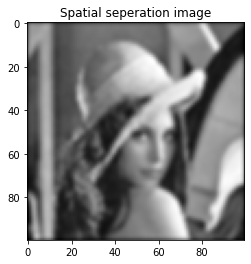

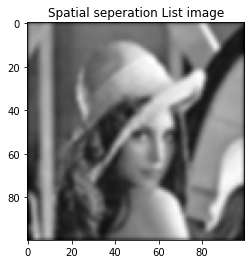

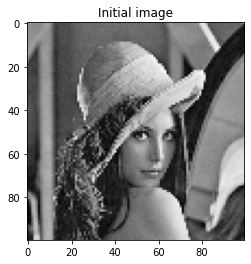

Number of multiplications used - 100000


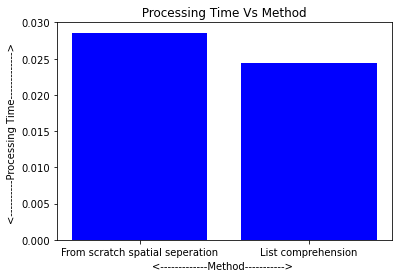

In [26]:
plt.imshow(filtered_image/255,cmap = "gray")
plt.title("Spatial seperation image")
plt.show()
plt.imshow(filtered_image_list,cmap = "gray")
plt.title("Spatial seperation List image")
plt.show()
plt.imshow(lena,cmap = "gray")
plt.title("Initial image")
plt.show()
print("Number of multiplications used - "+str(number_of_multiplications))

x = ['From scratch spatial seperation', 'List comprehension']
Processing_Times = [t2-t1,t3-t2]
x_pos = [i for i in range(len(x))]
plt.bar(x_pos, Processing_Times, color='blue')
plt.xlabel("<-------------Method-----------> ")
plt.ylabel("<----------Processing Time-------------> ")
plt.title(" Processing Time Vs Method ")
plt.xticks(x_pos, x)
plt.show()